<a href="https://colab.research.google.com/github/victormurcia/CTS_Test/blob/main/CTS_Unifying_Routines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#I need to import locale to ensure that the encoding is set to UTF-8 (weird Google Colab bug)
import locale
locale.getpreferredencoding = lambda: "UTF-8"

#Check the current build in Google Colab
!cat /etc/*release
print('\n')

#Check CUDA version
!nvcc --version
print('\n')

#Ensure that the required packages are installed in the current environment
install_pckgs = True
if install_pckgs == True:
  !pip install numpy --quiet
  !pip install pandas --quiet
  !pip install spacy==3.4.4 --quiet
  !pip install scispacy --quiet
  !pip install medspacy --quiet
  !pip install negspacy --quiet
  !pip install transformers
  !pip install seaborn --quiet
  !pip install matplotlib --quiet
  !pip install "dask[complete]" --quiet
  !pip install ipywidgets --quiet
  !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 --quiet 
  print('\n')

#Spacy models used for processing biomedical, scientific, or clinical text 
#Spacy pipeline for biomedical data.
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_sm-0.5.1.tar.gz --quiet
#Spacy pipeline for biomedical data. Has a larger vocabulary and 50k word vectors
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_md-0.5.1.tar.gz --quiet
#This one is another spacy pipeline with 785k vocabulary and uses scibert-base as a transformer model
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_scibert-0.5.1.tar.gz --quiet
#Spacy pipeline for biomedical data with 600k word vectors
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_lg-0.5.1.tar.gz --quiet
#A spaCy NER model trained on the CRAFT corpus.
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_craft_md-0.5.1.tar.gz --quiet
#A spaCy NER model trained on the JNLPBA corpus.
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_jnlpba_md-0.5.1.tar.gz --quiet
#A spaCy NER model trained on the BC5CDR corpus.
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bc5cdr_md-0.5.1.tar.gz --quiet
#A spaCy NER model trained on the BIONLP13CG corpus.
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bionlp13cg_md-0.5.1.tar.gz --quiet
#This is the med7 transformer model found here: https://github.com/kormilitzin/med7
!pip install https://huggingface.co/kormilitzin/en_core_med7_trf/resolve/main/en_core_med7_trf-any-py3-none-any.whl --quiet
#This is the med7 vector model 
!pip install https://huggingface.co/kormilitzin/en_core_med7_lg/resolve/main/en_core_med7_lg-any-py3-none-any.whl --quiet

DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=20.04
DISTRIB_CODENAME=focal
DISTRIB_DESCRIPTION="Ubuntu 20.04.5 LTS"
NAME="Ubuntu"
VERSION="20.04.5 LTS (Focal Fossa)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 20.04.5 LTS"
VERSION_ID="20.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=focal
UBUNTU_CODENAME=focal


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 45.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.5.0 requires spacy<3.6.0,>=3.5.

In [ ]:
#Import the required libraries/packages
#General utilities
import numpy as np
import pandas as pd
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt
import os, random, time,sys, re
from ipywidgets import widgets, interact, interactive, fixed, interact_manual
from tqdm import tqdm
import urllib.error
from ast import literal_eval
import ast

#NLP Stuff
#Spacy
import spacy
from spacy.lang.en.stop_words import STOP_WORDS #Load stopwords
from spacy.language import Language
from spacy.tokenizer import Tokenizer
#Scispacy
import scispacy
from scispacy.linking import EntityLinker
from scispacy.abbreviation import AbbreviationDetector
from scispacy.hyponym_detector import HyponymDetector
#Medspacy
import medspacy
from medspacy.ner import TargetRule
from medspacy.visualization import visualize_ent
from negspacy.negation import Negex

#To use Transformers models from HuggingFace
import transformers
from transformers import AutoTokenizer, AutoModel,AutoModelForTokenClassification
#NLTK

#Enable data to be extracted from my Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Load Patient Dataframe
#url ='https://raw.githubusercontent.com/victormurcia/CTS_Test/main/test_data/multi_veteran_df.csv'
url = 'https://raw.githubusercontent.com/victormurcia/CTS_Test/main/test_data/100_veteran_df.csv'
patients_df = pd.read_csv(url)
#patients_df

#Load the inclusion criteria
url ='https://raw.githubusercontent.com/victormurcia/CTS_Test/main/test_data/parsed_ct_ic.csv'
parsed_ct_ic = pd.read_csv(url)
#parsed_ct_ic

#Load the exclusion criteria
url ='https://raw.githubusercontent.com/victormurcia/CTS_Test/main/test_data/parsed_ct_ec.csv'
parsed_ct_ec = pd.read_csv(url)

In [ ]:
patients_df

,Unnamed: 0,CODE_als,DESCRIPTION_als,Id_cps,CODE_cps,DESCRIPTION_cps,REASONCODE_cps,REASONDESCRIPTION_cps,CODE_cds,DESCRIPTION_cds,...,LAT_pts,LON_pts,HEALTHCARE_EXPENSES_pts,HEALTHCARE_COVERAGE_pts,CODE_prs,DESCRIPTION_prs,REASONCODE_prs,REASONDESCRIPTION_prs,CODE_sps,DESCRIPTION_sps
0,0,[419474003.0],['Allergy to mould'],"['6db1454b-9d86-4e8d-bf6c-400fd6c7ea58', '16c6...","[384758001.0, 225358003.0, 170836005.0, 473870...","['Self-care interventions (procedure)', 'Wound...","[nan, 284551006.0, nan, 62106007.0, 263102004....","[nan, 'Laceration of foot', nan, 'Concussion w...","[65363002.0, 444814009.0, 232353008.0, 4448140...","['Otitis media', 'Viral sinusitis (disorder)',...",...,[32.70098618912568],[-117.04945240822256],[1057932.03],[9749.55],"[430193006.0, 430193006.0, 430193006.0, 430193...","['Medication Reconciliation (procedure)', 'Med...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",[],[]
1,1,"[424213003.0, 419474003.0, 232350006.0, 232347...","['Allergy to bee venom', 'Allergy to mould', '...","['a9a754ac-93be-43d8-8d8c-b2aa5ae21dff', 'b86a...","[711282006.0, 384758001.0, 225358003.0, 539500...","['Skin condition care', 'Self-care interventio...","[24079001.0, nan, 283371005.0, 10509002.0, 621...","['Atopic dermatitis', nan, 'Laceration of fore...","[195662009.0, 24079001.0, 283371005.0, 2419290...","['Acute viral pharyngitis (disorder)', 'Atopic...",...,[27.412811215030807],[-82.48709669044305],[1484154.97],[23366.439999999988],"[430193006.0, 117015009.0, 288086009.0, 313191...","['Medication Reconciliation (procedure)', 'Thr...","[nan, 195662009.0, 283371005.0, nan, nan, nan,...","[nan, 'Acute viral pharyngitis (disorder)', 'L...",[],[]
2,2,"[424213003.0, 419474003.0, 232350006.0, 232347...","['Allergy to bee venom', 'Allergy to mould', '...","['460a067e-440b-4e31-a95f-15cd14ca379d', '1f59...","[384758001.0, 91251008.0, 91251008.0, 44340200...","['Self-care interventions (procedure)', 'Physi...","[nan, 70704007.0, 44465007.0, 59621000.0, nan,...","[nan, 'Sprain of wrist', 'Sprain of ankle', 'H...","[195662009.0, 65363002.0, 70704007.0, 44481400...","['Acute viral pharyngitis (disorder)', 'Otitis...",...,[39.29315367777999],[-75.55846091806421],[1407342.1],[9708.3],"[430193006.0, 430193006.0, 430193006.0, 430193...","['Medication Reconciliation (procedure)', 'Med...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[409534002.0, 713779008.0, 469673003.0, 706724...",['Disposable air-purifying respirator (physica...
3,3,"[419474003.0, 232350006.0, 232347008.0, 418689...","['Allergy to mould', 'House dust mite allergy'...","['5e88e9c3-bfcf-4330-a2aa-c3ccac50c3ea', 'a9ac...","[91251008.0, 384758001.0, 699728000.0, 2253580...","['Physical therapy procedure', 'Self-care inte...","[44465007.0, nan, 233678006.0, 284551006.0, 26...","['Sprain of ankle', nan, 'Childhood asthma', '...","[44465007.0, 65363002.0, 444814009.0, 44609600...","['Sprain of ankle', 'Otitis media', 'Viral sin...",...,[27.876868587108994],[-82.72752198222165],[48207.53999999999],[0.0],"[430193006.0, 430193006.0, 430193006.0, 171231...","['Medication Reconciliation (procedure)', 'Med...","[nan, nan, nan, 233678006.0, nan, nan, nan, 28...","[nan, nan, nan, 'Childhood asthma', nan, nan, ...","[409534002.0, 713779008.0, 469673003.0, 706724...",['Disposable air-purifying respirator (physica...
4,4,"[419474003.0, 232350006.0, 232347008.0, 418689...","['Allergy to mould', 'House dust mite allergy'...","['bd2b9349-8052-473b-86d4-037a97669d66', '335d...","[384758001.0, 91251008.0, 91251008.0, 38569100...","['Self-care interventions (procedure)', 'Physi...","[nan, 70704007.0, 307731004.0, 263102004.0, 44...","[nan, 'Sprain of wrist', 'Injury of tendon of ...","[241929008.0, 367498001.0, 70704007.0, 4387800...","['Acute allergic reaction', 'Seasonal allergic...",...,[27.90661787167867],[-82.38400940952137],[526004.21],[4719.939999999999],"[430193006

In [ ]:
patients_df.columns

Index(['Unnamed: 0', 'CODE_als', 'DESCRIPTION_als', 'Id_cps', 'CODE_cps',
       'DESCRIPTION_cps', 'REASONCODE_cps', 'REASONDESCRIPTION_cps',
       'CODE_cds', 'DESCRIPTION_cds', 'CODE_dvs', 'DESCRIPTION_dvs', 'UDI_dvs',
       'Id_iss', 'BODYSITE_CODE_iss', 'BODYSITE_DESCRIPTION_iss',
       'MODALITY_CODE_iss', 'MODALITY_DESCRIPTION_iss', 'SOP_CODE_iss',
       'SOP_DESCRIPTION_iss', 'CODE_ims', 'DESCRIPTION_ims', 'CODE_mds',
       'DESCRIPTION_mds', 'DISPENSES_mds', 'TOTALCOST_mds', 'REASONCODE_mds',
       'REASONDESCRIPTION_mds', 'CODE_obs', 'DESCRIPTION_obs', 'VALUE_obs',
       'UNITS_obs', 'Id_pts', 'BIRTHDATE_pts', 'PREFIX_pts', 'MARITAL_pts',
       'RACE_pts', 'ETHNICITY_pts', 'GENDER_pts', 'BIRTHPLACE_pts', 'CITY_pts',
       'STATE_pts', 'COUNTY_pts', 'ZIP_pts', 'LAT_pts', 'LON_pts',
       'HEALTHCARE_EXPENSES_pts', 'HEALTHCARE_COVERAGE_pts', 'CODE_prs',
       'DESCRIPTION_prs', 'REASONCODE_prs', 'REASONDESCRIPTION_prs',
       'CODE_sps', 'DESCRIPTION_sps'],
      dt

In [ ]:
#Order of operations
# 1. Load the patients dataframe
# 2. Extract the EHR for the current patient
# 3. Preprocess each patient feature column
# 4. Run the NER model on each patient feature
# 5. Run a query on clinicaltrials.gov for all the conditions present in the patient profile
# 6. Extract the eligibility criteria for each queried clinical trial for each condition
# 7. Split eligibility criteria into inclusion/exclusion sections
# 8. Run NER model on both inclusion/exclusion sections
# 9. Determine Sorensen-Dice index between inclusion/exclusion sections and the patient EHR
# 10. Return the complete list of clinical trials stating whether the patient would qualify or not for each clinical trial

In [75]:
########################################################################################################
def str_to_list(s):
  """
  Convert a string representation of a list to a Python list.

  Args:
  s (str): A string representation of a list.

  Returns:
  list: The list represented by the input string.

  Raises:
  SyntaxError: If the input string is not a valid Python list.
  """
  # Replace 'nan' with 'None' for compatibility with ast.literal_eval
  s = s.replace("nan", "None")
  return ast.literal_eval(s)

########################################################################################################
def list_to_string(lst,mode):
  """
  Convert a list to a string using the specified mode.

  Args:
  lst (list): A list to convert to a string.
  mode (int): The mode to use for converting the list to a string. Must be 1 or 2.

  Returns:
  str: The list converted to a string using the specified mode. If the mode is invalid,
        returns 0.

  Raises:
  ValueError: If the mode is not 1 or 2.
  """
  if mode == 1:
    return ' '.join([str(i) if i is not None else 'None' for i in lst])
  elif mode == 2:
    return ''.join([str(i) if i is not None else 'None' for i in lst])
  else:
    print('Invalid Mode')
    return 0

########################################################################################################
def expand_list_to_df(final_patient_df,list_of_aspects,prefs):
  """
  Convert a list of aspects and corresponding prefixes into a Pandas DataFrame.

    Args:
        list_of_aspects (list): A list of aspects for each patient.
        prefs (list): A list of prefixes for each condition to be used for naming.

    Returns:
        pandas.DataFrame: A DataFrame containing the aspects and corresponding conditions
            for all patients.
    """
  df_list = []
  for i in range(len(list_of_aspects)):
    c_aspect = list(set(final_patient_df['Patient_Profile'][i]))
    pref = prefs[i]
    n_aspects = len(c_aspect)
    aspect_count = [pref + str(i) for i,x in enumerate(c_aspect)]
    aspect_dict = zip(aspect_count,c_aspect)
    aspect_df = pd.DataFrame(aspect_dict,columns=['aspects', 'Patient_Profile'])
    df_list.append(aspect_df)
  
  #Create dataframe from list of dataframes
  result = pd.concat(df_list).reset_index(drop=True)

  return result
########################################################################################################
def create_patient_df_for_NER(patients_df):
  """
  This function creates a dataframe for a single patient from the 
  """
  #Select a single row from the DataFrame
  row_data = patients_df.loc[0]

  #Create a new DataFrame with the single row
  patient_df = pd.DataFrame([row_data], columns=row_data.index)

  #Select columns that summarize patient profile and put them into a list
  allergies     = patient_df['DESCRIPTION_als'].apply(str_to_list)
  condition     = patient_df['DESCRIPTION_cds'].apply(str_to_list)
  devices       = patient_df['DESCRIPTION_dvs'].apply(str_to_list)
  immunizations = patient_df['DESCRIPTION_ims'].apply(str_to_list)
  medications   = patient_df['DESCRIPTION_mds'].apply(str_to_list)
  procedures    = patient_df['DESCRIPTION_prs'].apply(str_to_list)
  birthday      = patient_df['BIRTHDATE_pts'].apply(str_to_list)
  marital       = patient_df['MARITAL_pts'].apply(str_to_list)
  race          = patient_df['RACE_pts'].apply(str_to_list)
  ethnicity     = patient_df['ETHNICITY_pts'].apply(str_to_list)
  gender        = patient_df['GENDER_pts'].apply(str_to_list)
  city          = patient_df['CITY_pts'].apply(str_to_list)
  county        = patient_df['COUNTY_pts'].apply(str_to_list)

  ######################################################################################################
  #The data from the observation.csv files contain simulated unstructured data and requires different handling than the other elements.
  #1. Combine the observations, values, and units into a dictionary. Use observations as key. The most recent observation will be used.
  observations  = ast.literal_eval(patient_df['DESCRIPTION_obs'][0].replace("nan", "None"))
  values        = ast.literal_eval(patient_df['VALUE_obs'][0].replace("nan", "None"))
  units         = ast.literal_eval(patient_df['UNITS_obs'][0].replace("nan", "None"))

  #Combine the observations, values, and units into a dictionary. Use observations as key. The most recent observation will be used to define the patient.
  result_dict = dict(zip(observations, zip(values, units)))
  temp_df = pd.DataFrame.from_dict(result_dict).fillna('')
  new_row = temp_df.apply(lambda x: ' '.join(x), axis=0)
  obs_df = temp_df.append(new_row.transpose(), ignore_index=True).drop(index=[0, 1]).reset_index(drop=True).T.rename(columns={0: 'Patient_Profile'})
  obs_df['aspects'] = temp_df.columns
  obs_df = obs_df.reindex(columns=['aspects', 'Patient_Profile']).reset_index(drop=True)
  ######################################################################################################

  #Make list for patient profile
  patient_prof_list = [allergies, condition, devices, immunizations, medications, procedures, birthday, marital, race, ethnicity, gender, city, county]
  patient_prof_cols = ['allergies', 'condition', 'devices', 'immunizations', 'medications', 'procedures', 'birthday', 
                       'marital', 'race', 'ethnicity', 'gender', 'city', 'county']

  #Create a dictionary with column names and Series data
  data_dict = dict(zip(patient_prof_cols, patient_prof_list))

  #Create a new DataFrame with the single column
  patient_prof = pd.DataFrame(data_dict)

  #Concatenate the Series data into a single Series
  combined_series = pd.concat(patient_prof_list)

  #Create a DataFrame with a single column using the combined Series
  final_patient_df = pd.DataFrame({'Patient_Profile': combined_series})

  #Get column names of patient df
  final_patient_df['aspects'] = patient_prof_cols

  #Change the order of columns,reset the index, and drop the index column
  final_patient_df = final_patient_df.reindex(columns=['aspects', 'Patient_Profile']).reset_index().drop('index',axis=1)

  #Concatenate the oberservation df and the rest of the patient profile
  final_patient_df = pd.concat([final_patient_df, obs_df]).reset_index(drop=True)
  
  #Expand the categories of patient aspects so that every reading is in its own row instead of having a list
  list_of_aspects = final_patient_df['Patient_Profile'][0:5]
  prefs = ['allergy_', 'condition_','device_','immunization_','meds_','procedures_']
  result = expand_list_to_df(final_patient_df,list_of_aspects,prefs)
  final_patient_profile_df = pd.concat([final_patient_df,result]).reset_index(drop=True)
  final_patient_profile_df = final_patient_profile_df.drop(final_patient_profile_df.index[0:6]).reset_index(drop=True)
  
  #Convert the list column to a string column separated by a single space
  final_patient_profile_df['Patient_Profile'][:7] = final_patient_profile_df['Patient_Profile'][:7].apply(list_to_string, args = (1,))#.apply(lambda x: ' '.join(map(str, eval(x))))

  #Create new column that combines the aspects and Patient_Profile columns into a single column to be parsed
  final_patient_profile_df['text_to_parse'] = final_patient_profile_df['aspects'] + ' is ' + final_patient_profile_df['Patient_Profile']

  return final_patient_profile_df
########################################################################################################
def get_umls_codes(text: str, model, suffix, semantic_type_map):
  """
  Extracts UMLS codes, labels, and semantic mappings from a given text using a pre-trained spaCy model.

  Args:
  - text: input text to extract UMLS codes and labels from
  - model: pre-trained spaCy model to use for NLP tasks
  - suffix: a string to append to the keys in the output dictionary
  - semantic_type_map: a dictionary mapping UMLS semantic types to human-readable labels

  Returns:
  - list of dictionaries containing UMLS code information, labels, and semantic mappings for each entity in the text
  """
  # Process the text and extract UMLS codes
  doc = model(text)
  umls_codes = []

  for entity in doc.ents:
    for umls_ent in entity._.kb_ents:
      umls_id = umls_ent[0]
      umls_entity = model.get_pipe("scispacy_linker").kb.cui_to_entity[umls_id]
      semantic_type = umls_entity.types[0]
      mapped_type = semantic_type_map.get(semantic_type, "Unknown")

      umls_codes.append({
        "text" + suffix: entity.text,
        "umls_id" + suffix: umls_id,
        "score" + suffix: umls_ent[1],
        "label" + suffix: entity.label_,
        "semantic_mapping" + suffix: mapped_type
      })

  return umls_codes
########################################################################################################
def extract_values(dicts, key):
  """
  Extract a list of values corresponding to the specified key from a list of dictionaries.

    Args:
        dicts (list): A list of dictionaries.
        key (str): The key to extract values for.

    Returns:
        list: A list of values corresponding to the specified key. If the key is not present in a
              dictionary, None is returned for that dictionary.
    """
  return [d.get(key, None) for d in dicts]
########################################################################################################
def run_ner(df,col_name,model,semantic_type_map):
  """
  Extracts UMLS codes from text data in a given DataFrame column using a pre-trained spaCy model.

  Args:
  - df: pandas DataFrame containing the text data
  - col_name: string representing the name of the column in df that contains the text data
  - model: pre-trained spaCy model to use for NLP tasks

  Returns:
  - pandas DataFrame with new columns for each UMLS code extracted from the text data
  """

  if col_name == 'text_to_parse':#'Patient_Profile':
    ner_results_col = 'umls_codes_patient'
    suffix = '_pat'
  elif col_name == 'inclusion_criteria':
    ner_results_col = 'umls_codes_ic'
    suffix = '_ic'
  elif col_name == 'exclusion_criteria':
    ner_results_col = 'umls_codes_ec'
    suffix = '_ec'
  else:
    print('Invalid column name')

  #Run the NER model on patient df and get UMLS codes after parsing and entity linking
  df[ner_results_col] = df[col_name].apply(get_umls_codes, args = (model,suffix,semantic_type_map))

  # Create new columns from the keys in the dictionaries within the 'info' column lists
  unique_keys = set().union(*(d.keys() for dicts in df[ner_results_col] for d in dicts))

  #Unpack the dictionary keys into separate columns
  for key in unique_keys:
    df[key] = df[ner_results_col].apply(lambda dicts: extract_values(dicts, key))

  return df
########################################################################################################
def contains_multiple_words(s):
  """
  Check if a string is composed of multiple space-separated words.

  Args:
  s (str): A string to check.

  Returns:
  bool: True if the input string contains multiple space-separated words, False otherwise.
  """
  if len(s.split()) > 1:
    return True
  else:
    return False
########################################################################################################
def filter_list(list1, list2, values):
  """
  Returns a new list made by only returning the elements of list1 based on the values of list2.

  Parameters:
  list1 (list): The list of elements to filter.
  list2 (list): The list of values used for filtering.
  values (list): A list of values to filter on.

  Returns:
  list: A new list that contains only the elements of list1 where list2 is equal to any of the values in the values list.
  """
  new_list = [list1[i] for i in range(len(list2)) if list2[i] in values]
  return new_list
########################################################################################################
def get_list_of_conditions_from_patient_df(patient_ner_df,semantic_type_map):
  """
  """
  #Make lists of conditions and their semantic counterparts from the parsed patient dataframe
  list2 = patient_ner_df['semantic_mapping_pat'].explode().tolist()
  list1 = patient_ner_df['text_pat'].explode().tolist()

  #Return list of conditions that have been labeled with one of the terms below

  #Get all the values as a list
  labels =  list(semantic_type_map.values())#['Antibiotic','Clinical_Drug','Disease','Drug']
  #labels =  ['Antibiotic','Clinical_Drug','Disease','Drug']
  filtered_list = filter_list(list1, list2, labels)
  
  #Get list of conditions from parsed patient dataframe and remove duplicates
  list_of_conditions = list(set(filtered_list))

  # Remove nan values from the list using list comprehension and sort elements in alphabetical order
  list_of_conditions = sorted([x for x in list_of_conditions if not pd.isna(x)])

  # Define a regular expression pattern to match brackets and parentheses
  pattern = r"[\[\]\(\)]"

  # Remove brackets and parentheses from each element in the list
  list_of_conditions = [re.sub(pattern, "", str(elem)) for elem in list_of_conditions]

  return list_of_conditions
########################################################################################################
def get_clinical_trials(condition):
  """
  Creates a pandas dataframe from a query to clinicaltrials.gov

  Args:
  - condition: string representing the condition to search for

  Returns:
  - pandas dataframe with clinical trial data
  """
  #Check that condition is only 1 word else concatenate the string with a + sign
  multiword_condition = contains_multiple_words(condition)
  if multiword_condition == True:
    condition = "+".join(condition.split())
  #print(condition)
  a = 'https://clinicaltrials.gov/api/query/study_fields?expr='
  b = '&fields=NCTId%2CBriefTitle%2CCondition%2COverallStatus%2CEligibilityCriteria'
  c = '&min_rnk=1&max_rnk=1000&fmt=csv'
  q=(a + condition + b + c)
  #print(q)
  #qtrials_df = pd.read_csv(q,skiprows=10)
  # Read CSV data from URL and handle errors
  for i in range(5):
    try:
      qtrials_df = pd.read_csv(q, skiprows=10)
      break
    except urllib.error.URLError as e:
      print("URLError:", e.reason)
      print("Retrying in 5 seconds...")
      time.sleep(5)
    except urllib.error.HTTPError as e:
      if e.code == 500:
        print(condition,"HTTP Error 500: Internal Server Error")
      else:
        print("HTTP Error:", e.code)
      break
  else:
    raise ValueError("Unable to connect to the server after 5 attempts")
  return qtrials_df 
########################################################################################################
#PART 4. Query for clinical trials based on patient conditions
def query_trials_wrapper(list_of_conditions):
  """
  """
  list_of_cts = []
  for condition in list_of_conditions:
    #print(condition)
    qtrials_df = get_clinical_trials(condition)
    list_of_cts.append(qtrials_df)

  # Concatenate all DataFrames in the list into a single DataFrame
  all_trials_df = pd.concat(list_of_cts, ignore_index=True)

  return all_trials_df
########################################################################################################
def split_criteria(eligibility_criteria):
    # Split the input string
    substrings = eligibility_criteria.split('||')
    # Initialize the inclusion and exclusion criteria sections
    inclusion_criteria = ''
    exclusion_criteria = ''

    # Loop through the substrings to build the inclusion and exclusion criteria sections
    for i in range(len(substrings)):
        if 'Key Inclusion Criteria:' in substrings[i] or 'Inclusion Criteria:' in substrings[i]:
            if i+1 < len(substrings):
                inclusion_criteria += substrings[i+1]
        elif 'Key Exclusion Criteria:' in substrings[i] or 'Exclusion Criteria:' in substrings[i]:
            if i+1 < len(substrings):
                exclusion_criteria += substrings[i+1]

    # Return the inclusion and exclusion criteria sections as a tuple
    return pd.Series([inclusion_criteria, exclusion_criteria])
########################################################################################################
def calculate_SDI(patient_ner_df,parsed_trials_df):

  #Remove duplicates from the inclusion and exclusion criteria codes
  parsed_trials_df['umls_id_ic_clean'] = parsed_trials_df['umls_id_ic'].apply(lambda x: list(set(x)))
  parsed_trials_df['umls_id_ec_clean'] = parsed_trials_df['umls_id_ec'].apply(lambda x: list(set(x)))

  #Make list of patient umls codes, remove duplicates and remove NaNs
  patient_codes_list = sorted(list(set([x for x in patient_ner_df['umls_id_pat'].explode().tolist() if not pd.isna(x)])))

  # Compute Sorensen-Dice Index between the list of patient codes and the list of codes of the inclusion criteria for each clinical trial
  parsed_trials_df['SDI'] = parsed_trials_df['umls_id_ic_clean'].apply(lambda x: common_elements_and_sorensen_dice(patient_codes_list, x))

  return parsed_trials_df
########################################################################################################
def sorensen_dice_index(list1, list2) -> float:
    set1 = set(list1)
    set2 = set(list2)
    return 2 * len(set1.intersection(set2)) / (len(set1) + len(set2))
########################################################################################################
def common_elements_and_sorensen_dice(list1, list2):
  """
  This function finds the common elements between two lists and places these common elements into a new list.
  Then, the sorensen-dice index between this new list and list1 is calculated. 

  """
  # Find the common elements between the two lists
  common = list(set(list1).intersection(list2))

  # Calculate the Sorensen-Dice index
  dice_index = 2 * len(common) / (len(list1) + len(common))

  # Return the new list, its length, and the Sorensen-Dice index
  return dice_index
########################################################################################################
def cts_parser(patients_df,model):
  """
  This function parses the electronic health records for a patient extracted from the Synthetic Veteran Suicide Dataset and a set of 
  Clinical Trials queried using the clinicaltrials.gov API to determine how good of a match a patient is to a clinical trial.
  """
  #Start timer
  start_time = time.time()

  #PART 1. Create and prepare single patient dataframe for NER
  print('Step 1/9 : Creating dataframe for patient')
  final_patient_df = create_patient_df_for_NER(patients_df)
  
  #PART 2. Run the NER model on the patient EHR
  print('Step 2/9 : Run NER on patient data')

  # Define the semantic_type_map
  semantic_type_map = {
    "T116": "Protein",
    "T052": "Activity",
    "T100": "Age_Group",
    "T190": "Anatomical_Abnormality",
    "T017": "Anatomical_Structure",
    "T195": "Antibiotic",
    "T007": "Bacterium",
    "T031": "Body_Substance",
    "T053": "Behavior",
    "T029": "Body_Location",
    "T023": "Body_Part",
    "T103": "Chemical",
    "T200": "Clinical_Drug",
    "T060": "Diagnostic_Procedure",
    "T056": "Recreational_Activity",
    "T047": "Disease",
    "T121": "Drug",
    "T126": "Enzyme",
    "T099": "Family_Group",
    "T004": "Fungus",
    "T028": "Gene",
    "T096": "Group",
    "T131": "Hazardous_Substance",
    "T125": "Hormone",
    "T129": "Immunologic_Factor",
    "T197": "Inorganic_Chemical",
    "T037": "Injury",
    "T130": "Indicator",
    "T034": "Laboratory_Result",
    "T074": "Medical Device",
    "T048": "Mental_Dysfunction",
    "T109": "Organic_Chemical",
    "T001": "Organism",
    "T042": "Organ Function",
    "T067": "Phenomenon",
    "T121": "Pharmacologic_Substance",
    "T101": "Patient_Group",
    "T098": "Population_Group",
    "T081": "Quantitative_Concept",
    "T080": "Qualitative Concept",
    "T089": "Regulation",
    "T167": "Substance",
    "T054": "Social_Behavior",
    "T184": "Symptom",
    "T005": "Virus",
    "T127": "Vitamin"
    }
  patient_ner_df = run_ner(final_patient_df, 'text_to_parse', model, semantic_type_map)

  #PART 3. Get list of patient conditions after parsing EHR while also removing duplicates
  print('Step 3/9 : Creating list of patient conditions ')
  list_of_conditions = get_list_of_conditions_from_patient_df(patient_ner_df,semantic_type_map)
  print('Found ', len(list_of_conditions),' unique conditions on patient EHR')
  print(list_of_conditions)

  #PART 4. Query for clinical trials based on patient conditions and generate CT dataframe
  print('Step 4/9 : Querying for clinical trials')
  all_trials_df = query_trials_wrapper(list_of_conditions)

  #PART 5. Get dataframe containing only clinical trials that are actively recruiting
  print('Step 5/9 : Only include clinical trials that are actively recruiting')
  recruiting_trials_df = all_trials_df[all_trials_df['OverallStatus']=='Recruiting'].reset_index()

  #PART 6. Create inclusion and inclusion criteria columns on dataframe for subsequent parsing
  print('Step 6/9 : Split eligibility criteria into inclusion and exclusion sections')
  recruiting_trials_df[['inclusion_criteria', 'exclusion_criteria']] = recruiting_trials_df['EligibilityCriteria'].astype(str).apply(split_criteria)
  nTrials = recruiting_trials_df.shape[0]
  print('Found ', nTrials, ' for current patient')
  #PART 7-8. Run the NER model on the eligibility criteria from the clinical trial df
  print('Step 7/9 : Run NER on Clinical Trial Inclusion Criteria')
  parsed_trials_df = run_ner(recruiting_trials_df,'inclusion_criteria',model,semantic_type_map)
  print('Step 8/9 : Run NER on Clinical Trial Exclusion Criteria')
  parsed_trials_df = run_ner(parsed_trials_df,'exclusion_criteria',model,semantic_type_map)

  #PART 9. Determine whether parsed patient profile has any criteria that is present on the exclusion criteria list
  print('Step 9/9 : Calculate Sorensen-Dice Index between Patient Codes and Clinical Trial Eligibility Codes')
  final_df = calculate_SDI(patient_ner_df,parsed_trials_df)

  #End timer
  print("Parsing patient records took: %.2f seconds" % (time.time() - start_time))

  return final_patient_df,patient_ner_df,recruiting_trials_df,final_df

In [ ]:
#List of available models
models = ["en_core_sci_sm","en_core_sci_md","en_core_sci_lg","en_core_sci_scibert","en_ner_craft_md","en_ner_jnlpba_md","en_ner_bionlp13cg_md","en_core_med7_lg"]

#Load the pre-trained spaCy NER model with sci-spaCy
model = spacy.load(models[0])

#Add the Negation pipe to spacy pipeline
if 'negex' not in model.pipe_names:
  model.add_pipe("negex")

#Add the abbreviation pipe to the spacy pipeline.
if 'abbreviation_detector' not in model.pipe_names:
  model.add_pipe("abbreviation_detector")
  
#Add the EntityLinker pipe to spacy pipeline
if 'scispacy_linker' not in model.pipe_names:
  model.add_pipe("scispacy_linker", config={"linker_name": "umls", "max_entities_per_mention": 1})

https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2020-10-09/umls/tfidf_vectors_sparse.npz not found in cache, downloading to /tmp/tmphe07kl9g
Finished download, copying /tmp/tmphe07kl9g to cache at /root/.scispacy/datasets/e9f7327283e43f0482f7c0c71b71dec278a58ccb3ffdd03c2c2350159e7ef146.f2a350ad19015b2591545f7feeed6a6d6d2fffcd635d868a5d7fc0dfc3cadfd8.tfidf_vectors_sparse.npz
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2020-10-09/umls/nmslib_index.bin not found in cache, downloading to /tmp/tmp5tcy20j_
Finished download, copying /tmp/tmp5tcy20j_ to cache at /root/.scispacy/datasets/f48455d6c79262057cce66b4619123c2b558b21092d42fac97f47bb99a5b8f9f.dd70d3dffe7d90d7ac8914460e16a48375dab32485fb6313a34e6fbcaf53218b.nmslib_index.bin
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2020-10-09/umls/tfidf_vectorizer.joblib not found in cache, downloading to /tmp/tmpsq4yjc0q
Finished download, copying /tmp/tmpsq4yjc0q to cache at /root/.scispacy/da

In [ ]:
model.pipe_names

['tok2vec',
 'tagger',
 'attribute_ruler',
 'lemmatizer',
 'parser',
 'ner',
 'negex',
 'abbreviation_detector',
 'scispacy_linker']

In [ ]:
pd.set_option("display.max_columns", 10)
pd.set_option("display.max_rows", 10)
final_patient_df,patient_ner_df,recruiting_trials_df,final_df = cts_parser(patients_df,model)
patient_ner_df

Step 1/9 : Creating dataframe for patient
Step 2/9 : Run NER on patient data
Step 3/9 : Creating list of patient conditions 
Found  59  unique conditions on patient EHR
['Ab', 'Acetaminophen', 'Acute viral pharyngitis', 'Ag', 'Amoxicillin', 'Arterial blood', 'BMI', 'Blood', 'Body Mass Index', 'Body mass index', 'COVID-19', 'Cat dander', 'Chronic sinusitis', 'Cladosporium herbarum', 'Clavulanate', 'Concussion', 'Doxycycline', 'Fatigue', 'Fever', 'Fracture subluxation', 'Head', 'Headache', 'Hemoglobin', 'Hep A', 'Hep B', 'Hib', 'High Density Lipoprotein Cholesterol', 'IPV', 'IgE', 'IgE Ab', 'Influenza virus A', 'Influenza virus B Ag', 'Laceration', 'Latex', 'MCV', 'Naproxen sodium', 'Nasopharynx', 'Nausea', 'Otitis media', 'Penicillin V', 'Perennial allergic rhinitis', 'Serum', 'Sinusitis', 'Streptococcal sore throat', 'Tobacco smoking', 'Triglycerides', 'Viral sinusitis', 'Vomiting symptom', 'Whiplash injury', 'adult', 'combat', 'disorder', 'ethnicity', 'finding', 'narrative', 'obesity'

,aspects,Patient_Profile,text_to_parse,umls_codes_patient,label_pat,semantic_mapping_pat,text_pat,score_pat,umls_id_pat
0,birthday,1975-03-24,birthday is 1975-03-24,"[{'text_pat': 'birthday', 'umls_id_pat': 'C042...",[ENTITY],[Unknown],[birthday],[0.8192237615585327],[C0421451]
1,marital,M,marital is M,"[{'text_pat': 'marital', 'umls_id_pat': 'C0024...",[ENTITY],[Unknown],[marital],[1.0],[C0024841]
2,race,white,race is white,"[{'text_pat': 'race', 'umls_id_pat': 'C0034510...","[ENTITY, ENTITY]","[Population_Group, Population_Group]","[race, white]","[1.0, 1.0]","[C0034510, C0007457]"
3,ethnicity,nonhispanic,ethnicity is nonhispanic,"[{'text_pat': 'ethnicity', 'umls_id_pat': 'C00...",[ENTITY],[Population_Group],[ethnicity],[1.0],[C0015031]
4,gender,M,gender is M,"[{'text_pat': 'gender', 'umls_id_pat': 'C00793...",[ENTITY],[Unknown],[gender],[1.0],[C0079399]
...,...,...,...,...,...,...,...,...,...
90,meds_2,Doxycycline Monohydrate 50 MG Oral Tablet,meds_2 is Doxycycline Monohydrate 50 MG Oral T...,"[{'text_pat': 'Doxycycline', 'umls_id_pat': 'C...","[ENTITY, ENTITY, ENTITY]","[Organic_Chemical, Unknown, Unknown]","[Doxycycline, MG, Oral Tablet]","[1.0, 1.0, 1.0]","[C0013090, C0024443, C0993159]"
91,meds_3,Naproxen sodium 220 MG Oral Tablet,meds_3 is Naproxen sodium 220 MG Oral Tablet,"[{'text_pat': 'Naproxen sodium', 'umls_id_pat'...","[ENTITY, ENTITY, ENTITY]","[Organic_Chemical, Unknown, Unknown]","[Naproxen sodium, MG, Oral Tablet]","[1.0, 1.0, 1.0]","[C0546873, C0024443, C0993159]"
92,meds_4,diphenhydrAMINE Hydrochloride 25 MG Oral Tablet,meds_4 is diphenhydrAMINE Hydrochloride 25 MG ...,"[{'text_pat': 'Oral Tablet', 'umls_id_pat': 'C...",[ENTITY],[Unknown],[Oral Tablet],[1.0],[C0993159]
93,meds_5,Amoxicillin 250 MG / Clavulanate 125 MG Oral T...,meds_5 is Amoxicillin 250 MG / Clavulanate 125...,"[{'text_pat': 'Amoxicillin', 'umls_id_pat': 'C...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY]","[Organic_Chemical, Unknown, Organic_Chemical, ...","[Amoxicillin, MG, Clavulanate, MG, Oral Tablet]","[1.0, 1.0, 1.0, 1.0, 1.0]","[C0002645, C0024443, C0110038, C0024443, C0993..."


In [ ]:
pd.set_option("display.max_columns", 25)
final_df

,index,Rank,NCTId,BriefTitle,Condition,OverallStatus,EligibilityCriteria,inclusion_criteria,exclusion_criteria,umls_codes_ic,label_ic,text_ic,umls_id_ic,score_ic,semantic_mapping_ic,umls_codes_ec,score_ec,semantic_mapping_ec,label_ec,text_ec,umls_id_ec,umls_id_ic_clean,umls_id_ec_clean,SDI
0,3,4,NCT05617755,"AB-1015, an Integrated Circuit T (ICT) Cell Th...","Carcinoma, Ovarian Epithelial|Ovarian Neoplasm...",Recruiting,"Inclusion Criteria:||Recurrent, advanced, plat...","Recurrent, advanced, platinum resistant ovaria...",Cytotoxic chemotherapy within 14 days of time ...,"[{'text_ic': 'Recurrent', 'umls_id_ic': 'C2945...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[Recurrent, advanced, platinum resistant, ovar...","[C2945760, C0205179, C4688006, C0205065, C0015...","[0.9999998807907104, 1.0, 0.8688523173332214, ...","[Unknown, Unknown, Unknown, Body_Part, Body_Pa...","[{'text_ec': 'Cytotoxic chemotherapy', 'umls_i...","[1.0, 1.0, 0.7621618509292603, 1.0, 1.0, 0.958...","[Unknown, Unknown, Unknown, Unknown, Body_Part...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[Cytotoxic chemotherapy, days, cell collection...","[C0677881, C0439228, C0677881, C0439228, C0031...","[C0205179, C0439231, C0006610, C0242656, C0015...","[C0036043, C0677881, C0031153, C0021079, C0332...",0.015748
1,5,6,NCT05013086,177Lu-AB-3PRGD2 in Patients With Non Small Cel...,Non Small Cell Lung Cancer,Recruiting,Inclusion Criteria:||confirmed NSCLC patients;...,confirmed NSCLC patients;|tumor lesions with h...,the exclusion criteria were a serum creatinine...,"[{'text_ic': 'NSCLC', 'umls_id_ic': 'C0007131'...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTITY]","[NSCLC, lesions, PET/CT, week, injection, writ...","[C0007131, C0221198, C1699633, C0439230, C0021...","[1.0, 1.0, 1.0, 1.0, 1.0, 0.802409827709198]","[Unknown, Unknown, Diagnostic_Procedure, Unkno...","[{'text_ec': 'exclusion criteria', 'umls_id_ec...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999403953...","[Unknown, Unknown, Unknown, Protein, Unknown, ...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[exclusion criteria, serum creatinine, level, ...","[C0680251, C0201976, C0441889, C0019046, C0441...","[C1576874, C0221198, C0021485, C1699633, C0007...","[C0005437, C0871010, C0201976, C0009924, C0008...",0.000000
2,16,17,NCT05211570,AB8939 in Patients With Relapsed/Refractory Ac...,Acute Myeloid Leukemia Refractory|Acute Myeloi...,Recruiting,DOSE ESCALATION STUDY||Key Inclusion Criteria:...,Patients with documented diagnosis of acute my...,Patients eligible to a standard of care|Patien...,"[{'text_ic': 'Patients', 'umls_id_ic': 'C00307...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[Patients, documented, diagnosis, acute myeloi...","[C0030705, C1301725, C0011900, C0023467, C0023...","[1.0, 1.0, 0.9999998807907104, 1.0, 1.0, 1.0, ...","[Patient_Group, Unknown, Diagnostic_Procedure,...","[{'text_ec': 'Patients', 'umls_id_ec': 'C00307...","[1.0, 1.0, 0.8145785927772522, 1.0, 1.0, 0.725...","[Patient_Group, Unknown, Patient_Group, Unknow...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[Patients, standard, care|Patients, hematopoie...","[C0030705, C1442989, C0030705, C0472699, C0472...","[C5206740, C0030705, C0333052, C0011900, C0043...","[C0006147, C0472699, C0030705, C0032961, C0011...",0.000000
3,21,22,NCT04943185,"A Prospective, Single Surgeon, Randomized Cont...",The Objective of the Study is to Prospectively...,Recruiting,Inclusion Criteria:||Patients with maximally t...,Patients with maximally tolerated medically tr...,Non-Ocular,"[{'text_ic': 'Patients', 'umls_id_ic': 'C00307...","[ENTITY, ENTITY, ENTITY, ENTITY, ENTITY, ENTIT...","[Patients, maximally tolerated medically treat...","[C0030705, C0752079, C0752079, C0339573, C0271...","[1.0, 0.7951071858406067, 0.7951071858406067, ...","[Patient_Group, Unknown, Unknown, Disease, Dis...",[],[],[],[],[],[],"[C0030705, C0003629, C0752079, C0302828, C0439...",[],0.015748
4,22,23,NCT05577416,A Study of AB-218 in P

In [49]:
fdf = final_df[['NCTId','BriefTitle','Condition','EligibilityCriteria','text_ic','semantic_mapping_ic','SDI']]
fdf

,NCTId,BriefTitle,Condition,EligibilityCriteria,text_ic,semantic_mapping_ic,SDI
0,NCT05617755,"AB-1015, an Integrated Circuit T (ICT) Cell Th...","Carcinoma, Ovarian Epithelial|Ovarian Neoplasm...","Inclusion Criteria:||Recurrent, advanced, plat...","[Recurrent, advanced, platinum resistant, ovar...","[Unknown, Unknown, Unknown, Body_Part, Body_Pa...",0.015748
1,NCT05013086,177Lu-AB-3PRGD2 in Patients With Non Small Cel...,Non Small Cell Lung Cancer,Inclusion Criteria:||confirmed NSCLC patients;...,"[NSCLC, lesions, PET/CT, week, injection, writ...","[Unknown, Unknown, Diagnostic_Procedure, Unkno...",0.000000
2,NCT05211570,AB8939 in Patients With Relapsed/Refractory Ac...,Acute Myeloid Leukemia Refractory|Acute Myeloi...,DOSE ESCALATION STUDY||Key Inclusion Criteria:...,"[Patients, documented, diagnosis, acute myeloi...","[Patient_Group, Unknown, Diagnostic_Procedure,...",0.000000
3,NCT04943185,"A Prospective, Single Surgeon, Randomized Cont...",The Objective of the Study is to Prospectively...,Inclusion Criteria:||Patients with maximally t...,"[Patients, maximally tolerated medically treat...","[Patient_Group, Unknown, Unknown, Disease, Dis...",0.015748
4,NCT05577416,A Study of AB-218 in Patients With IDH1 Mutate...,Glioma,Inclusion Criteria:||Patients will have a radi...,"[Patients, radiological diagnosis, LGG, LGG, e...","[Patient_Group, Diagnostic_Procedure, Bacteriu...",0.000000
...,...,...,...,...,...,...,...
5298,NCT04344470,Study of Volition: Behavioral Analysis and Cli...,Normal Physiology,INCLUSION CRITERIA:||In order to be eligible t...,[],[],0.000000
5299,NCT05415163,Vascular Photobiomodulation on Sleep Qualityan...,Stress Disorder|Sleep Disorder,Inclusion Criteria:||poor sleep quality.|Parti...,"[months, poor sleep quality, score, points, me...","[Unknown, Unknown, Unknown, Diagnostic_Procedu...",0.015748
5300,NCT05592613,Next Generation Ingestible Sensors for Medicat...,"HIV Infection|Adherence, Medication|Adherence,...",Inclusion Criteria:||PrEP Participants:||Age 1...,"[PrEP, Participants]","[Gene, Population_Group]",0.000000
5301,NCT03011294,"Cardiovascular Impact, Quality e Quantity of S...",Sleep Apnea Syndromes,Inclusion Criteria:||Bed partners of patients ...,"[Bed partners, patients, moderate, severe, OSA]","[Unknown, Patient_Group, Unknown, Unknown, Dis...",0.000000


In [72]:
fdf['EligibilityCriteria'][335]

'Inclusion Criteria:||Children from 2 to 59 months of age;|Acute fever (axillary temperature over or equal to 37.5°) or history of fever within the past 7 days;|Available to return for the follow-up visit at the health facility on day 7 (±2).|Written informed consent obtained from parents/legal guardian.||Exclusion Criteria:||Children less than 2 months or over 59 months;|Presence of signs and symptoms of severe infections;|Children with chronic febrile infections.'

In [ ]:
final_df['SDI'].max()

0.10526315789473684

In [ ]:
pd.set_option("display.max_rows", 100)
patient_ner_df

,aspects,Patient_Profile,text_to_parse,umls_codes_patient,label_pat,semantic_mapping_pat,text_pat,score_pat,umls_id_pat
0,birthday,1975-03-24,birthday is 1975-03-24,"[{'text_pat': 'birthday', 'umls_id_pat': 'C042...",[ENTITY],[Unknown],[birthday],[0.8192237615585327],[C0421451]
1,marital,M,marital is M,"[{'text_pat': 'marital', 'umls_id_pat': 'C0024...",[ENTITY],[Unknown],[marital],[1.0],[C0024841]
2,race,white,race is white,"[{'text_pat': 'race', 'umls_id_pat': 'C0034510...","[ENTITY, ENTITY]","[Population_Group, Population_Group]","[race, white]","[1.0, 1.0]","[C0034510, C0007457]"
3,ethnicity,nonhispanic,ethnicity is nonhispanic,"[{'text_pat': 'ethnicity', 'umls_id_pat': 'C00...",[ENTITY],[Population_Group],[ethnicity],[1.0],[C0015031]
4,gender,M,gender is M,"[{'text_pat': 'gender', 'umls_id_pat': 'C00793...",[ENTITY],[Unknown],[gender],[1.0],[C0079399]
5,city,Chula Vista,city is Chula Vista,"[{'text_pat': 'city', 'umls_id_pat': 'C0008848...",[ENTITY],[Unknown],[city],[1.0],[C0008848]
6,county,San Diego County,county is San Diego County,"[{'text_pat': 'county', 'umls_id_pat': 'C00791...",[ENTITY],[Unknown],[county],[0.9999999403953552],[C0079170]
7,Body Height,182.3 cm,Body Height is 182.3 cm,"[{'text_pat': 'Body Height', 'umls_id_pat': 'C...",[ENTITY],[Unknown],[Body Height],[1.0],[C0005890]
8,Pain severity - 0-10 verbal numeric rating [Sc...,0.0 {score},Pain severity - 0-10 verbal numeric rating [Sc...,"[{'text_pat': 'Pain severity', 'umls_id_pat': ...","[ENTITY, ENTITY, ENTITY]","[Unknown, Unknown, Unknown]","[Pain severity, Score, Reported]","[0.9999998807907104, 1.0, 1.0]","[C1507013, C0449820, C0684224]"
9,Body Weight,100.5 kg,Body Weight is 100.5 kg,"[{'text_pat': 'Body Weight', 'umls_id_pat': 'C...",[ENTITY],[Unknown],[Body Weight],[1.0],[C0005910]


In [50]:
pdf_red = patient_ner_df[['aspects','Patient_Profile','text_to_parse','label_pat','semantic_mapping_pat','text_pat']]
pdf_red[30:60]

,aspects,Patient_Profile,text_to_parse,label_pat,semantic_mapping_pat,text_pat
30,Peanut IgE Ab in Serum,0.3 kU/L,Peanut IgE Ab in Serum is 0.3 kU/L,"[ENTITY, ENTITY, ENTITY, ENTITY]","[Unknown, Protein, Protein, Body_Substance]","[Peanut, IgE, Ab, Serum]"
31,Walnut IgE Ab in Serum,0.3 kU/L,Walnut IgE Ab in Serum is 0.3 kU/L,"[ENTITY, ENTITY]","[Unknown, Body_Substance]","[Walnut IgE Ab, Serum]"
32,Codfish IgE Ab in Serum,0.0 kU/L,Codfish IgE Ab in Serum is 0.0 kU/L,[ENTITY],[Body_Substance],[Serum]
33,Shrimp IgE Ab in Serum,0.1 kU/L,Shrimp IgE Ab in Serum is 0.1 kU/L,[ENTITY],[Body_Substance],[Serum]
34,Wheat IgE Ab in Serum,0.3 kU/L,Wheat IgE Ab in Serum is 0.3 kU/L,"[ENTITY, ENTITY, ENTITY]","[Unknown, Protein, Body_Substance]","[Wheat, Ab, Serum]"
35,Egg white IgE Ab in Serum,0.1 kU/L,Egg white IgE Ab in Serum is 0.1 kU/L,"[ENTITY, ENTITY]","[Unknown, Body_Substance]","[Egg white IgE Ab, Serum]"
36,Soybean IgE Ab in Serum,0.1 kU/L,Soybean IgE Ab in Serum is 0.1 kU/L,"[ENTITY, ENTITY, ENTITY]","[Unknown, Protein, Body_Substance]","[Soybean, IgE, Serum]"
37,Cow milk IgE Ab in Serum,0.3 kU/L,Cow milk IgE Ab in Serum is 0.3 kU/L,"[ENTITY, ENTITY, ENTITY]","[Unknown, Protein, Body_Substance]","[Cow milk, IgE Ab, Serum]"
38,White oak IgE Ab in Serum,0.2 kU/L,White oak IgE Ab in Serum is 0.2 kU/L,"[ENTITY, ENTITY]","[Unknown, Body_Substance]","[White oak IgE Ab, Serum]"
39,Common Ragweed IgE Ab in Serum,0.2 kU/L,Common Ragweed IgE Ab in Serum is 0.2 kU/L,"[ENTITY, ENTITY, ENTITY]","[Unknown, Protein, Body_Substance]","[Ragweed IgE, Ab, Serum]"


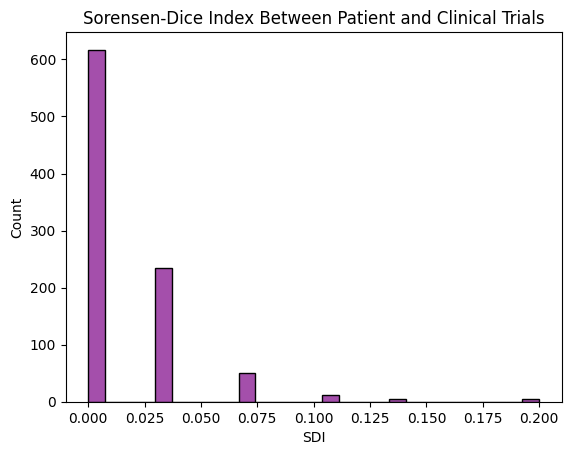

In [ ]:
# plot a histogram of the 'age' column using Seaborn
sns.histplot(data=final_df, x='SDI',color='#86148f').set_title('Sorensen-Dice Index Between Patient and Clinical Trials')
plt.show()

In [ ]:
patient_ner_df.to_csv('parsed_patient_ehr.csv', index=False)
recruiting_trials_df.to_csv('recruiting_clinical_trials.csv', index=False)
final_df.to_csv('parsed_clinical_trials.csv', index=False)

In [74]:
# Load the SciSpaCy model
#nlp = spacy.load("en_core_sci_lg")

# Text containing the concept and numerical quantity
text = "Written informed consent obtained from parents/legal guardian"

# Process the text and perform NER
doc = model(text)

# Print entities and their labels
for ent in doc.ents:
    print(f"Entity: {ent.text}, Label: {ent.label_}")

Entity: Written informed consent, Label: ENTITY
Entity: parents/legal, Label: ENTITY
